<a href="https://colab.research.google.com/github/bimarshak7/finetuning-hf-models/blob/main/LayoutLM_SequenceClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Install necessary libraries
!pip install transformers -q
!pip install pytesseract -q
!pip install -q datasets seqeval
!sudo apt install tesseract-ocr -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.2 MB/s eta 0:00:00
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 15 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 3.)
debconf: falling back to frontend: Readline
debconf: unable t

In [2]:
import datasets
datasets.__version__

'2.15.0'

# LayoutLM- SequenceClassification
Original Paper: https://arxiv.org/abs/1912.13318

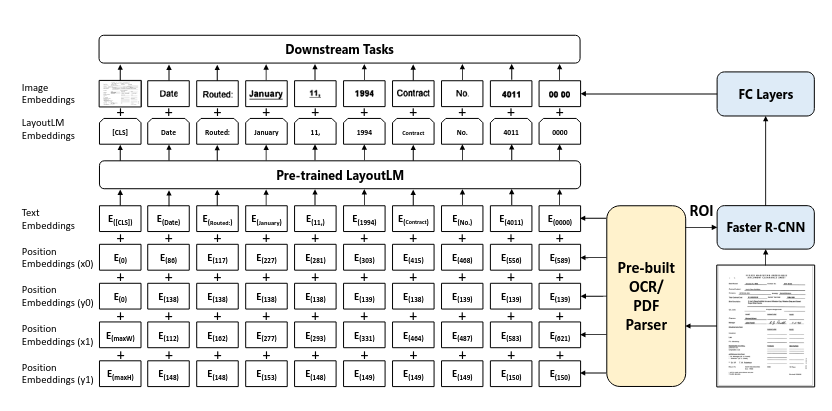

Here, we are goint to use LayoutLMforSequence Classification which doesn't make use of Image Embeddings rather user tokenized of ocr texts and corresponding bounding boxes.

In [1]:
# Import Necessary Libraries
from datasets import Dataset,load_dataset #huggingface dataset module
import matplotlib.pyplot as plt
import numpy as np
import pytesseract
from PIL import Image, ImageDraw, ImageFont

In [2]:
DATASET_NAME = "jordyvl/rvl_cdip_100_examples_per_class"

In [3]:
# load dataste from hugging face hub
train_ds = load_dataset(DATASET_NAME,split="train")
val_ds = load_dataset(DATASET_NAME,split="validation")

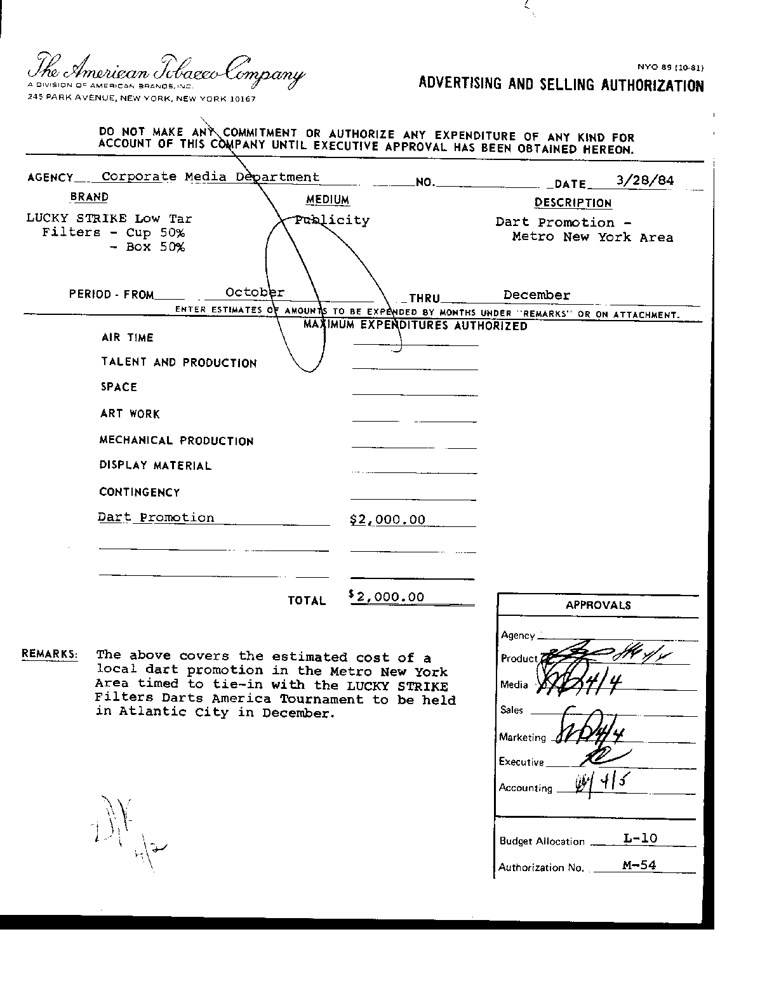

In [73]:
#Have a look at a sample Image
from PIL import Image, ImageDraw, ImageFont

image = train_ds[77]["image"]
image = image.convert("RGB")
image

In [5]:
#Apply OCR in sample image,
import pytesseract
import numpy as np

ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
ocr_df = ocr_df.dropna().reset_index(drop=True)
float_cols = ocr_df.select_dtypes('float').columns
ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
words = ' '.join([word for word in ocr_df.text if str(word) != 'nan'])
words

"> a, wero esio8n He tnerican Iebacoo Cimpany ADVERTISING AND SELLING AUTHORIZATION DO NOT MAKE ANY COMMITMENT OR AUTHORIZE ANY EXPENDITURE OF ANY KIND FOR ACCOUNT OF THIS COMPANY UNTIL EXECUTIVE APPROVAL HAS BEEN OBTAINED HEREON. Aceuey__Corporate vedia Ddgartment BRAND LUCKY STRIKE Low Tar Filters - Cup 50x = Box 50% No. —pate__3/28/84 DESCRIPTION Dart Promotion - Metro New York Area _Tieu December EuTEH ESTUATES Of avQUNAE To wt exeluoeD BY MONTHS UNDER “REMARAS' OR Ow ATTACINEMT MAXIMUM EXPENDITURES ‘AUTHORIZED AIR TIME —}— TALENT AND PRODUCTION Se PERIOD - FROM. SPACE ART WORK MECHANICAL PRODUCTION DISPLAY MATERIAL _ CONTINGENCY Dart Promotion $2,000.00 Tora, $2,000.00 ‘APPROVALS REMARKS: The above covers the estimated cost of a local dart promotion in the Metro New York Area timed to tie-in with the LUCKY STRIKE Filters Darts America Tournament to be held in Atlantic City in December. Executive ecouting WL AIS. Budget Allocation L-10 | Authorization No, Mn54"

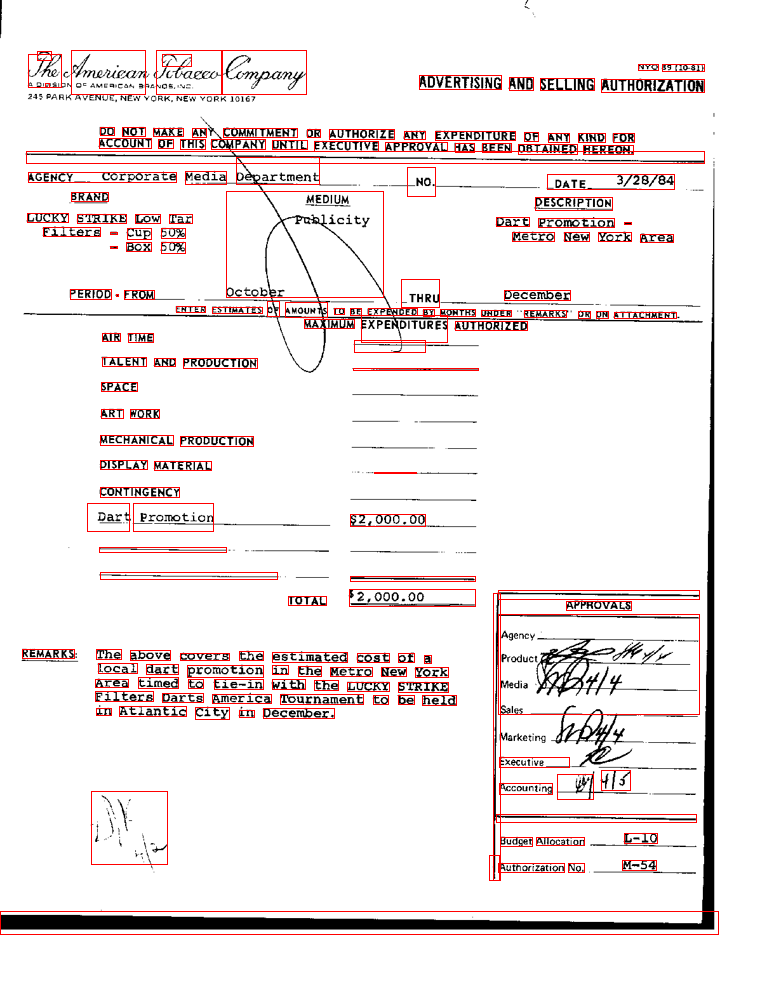

In [6]:
coordinates = ocr_df[['left', 'top', 'width', 'height']]
actual_boxes = []
for idx, row in coordinates.iterrows():
    #change bbox from x1,y1,w,h to x1,y1,x2,y2
    x, y, w, h = tuple(row)
    actual_box = [x, y, x+w, y+h]
    actual_boxes.append(actual_box)

draw = ImageDraw.Draw(image, "RGB")
for box in actual_boxes:
  draw.rectangle(box, outline='red')

image

In [7]:
def normalize_box(box, width, height):
  """normalize the bounding boxes to be on a 0-1000 scale"""
  return [
      int(1000 * (box[0] / width)),
      int(1000 * (box[1] / height)),
      int(1000 * (box[2] / width)),
      int(1000 * (box[3] / height)),
     ]

In [8]:
def apply_ocr(example):
        """Function to extract texts from document with bounding boxes for each word using google tesseract-ocr"""
        # get the image
        image = example['image']

        width, height = image.size

        # apply ocr to the image
        ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
        float_cols = ocr_df.select_dtypes('float').columns
        ocr_df = ocr_df.dropna().reset_index(drop=True)
        ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
        ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
        ocr_df = ocr_df.dropna().reset_index(drop=True)

        # get the words and actual (unnormalized) bounding boxes
        #words = [word for word in ocr_df.text if str(word) != 'nan'])
        words = list(ocr_df.text)
        words = [str(w) for w in words]
        coordinates = ocr_df[['left', 'top', 'width', 'height']]
        actual_boxes = []
        for idx, row in coordinates.iterrows():
            #change bbox from x1,y1,w,h to x1,y1,x2,y2
            x, y, w, h = tuple(row)
            actual_box = [x, y, x+w, y+h]
            actual_boxes.append(actual_box)

        # normalize the bounding boxes
        boxes = []
        for box in actual_boxes:
            boxes.append(normalize_box(box, width, height))

        # add as extra columns
        example['words'] = words
        example['bbox'] = boxes
        return example

In [9]:
train_ds = train_ds.map(apply_ocr)

In [10]:
val_ds = val_ds.map(apply_ocr)

In [11]:
labels = train_ds.features["label"].names
idx2label = {v: k for v, k in enumerate(labels)}
label2idx = {k: v for v, k in enumerate(labels)}
label2idx

{'letter': 0,
 'form': 1,
 'email': 2,
 'handwritten': 3,
 'advertisement': 4,
 'scientific report': 5,
 'scientific publication': 6,
 'specification': 7,
 'file folder': 8,
 'news article': 9,
 'budget': 10,
 'invoice': 11,
 'presentation': 12,
 'questionnaire': 13,
 'resume': 14,
 'memo': 15}

In [12]:
from transformers import LayoutLMTokenizer
import torch

In [13]:
tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")

In [14]:
def encode_example(example, max_seq_length=512, pad_token_box=[0, 0, 0, 0]):
  words = example['words']
  normalized_word_boxes = example['bbox']

  assert len(words) == len(normalized_word_boxes)

  token_boxes = []
  for word, box in zip(words, normalized_word_boxes):
      word_tokens = tokenizer.tokenize(word)
      #if multiple words are detected in single bbox, we use same bbox for them
      token_boxes.extend([box] * len(word_tokens))

  # Truncation of token_boxes
  special_tokens_count = 2
  if len(token_boxes) > max_seq_length - special_tokens_count:
      token_boxes = token_boxes[: (max_seq_length - special_tokens_count)]

  # add bounding boxes of cls + sep tokens
  token_boxes = [[0, 0, 0, 0]] + token_boxes + [[1000, 1000, 1000, 1000]]

  encoding = tokenizer(' '.join(words), padding='max_length', truncation=True)
  # Padding of token_boxes up the bounding boxes to the sequence length.
  input_ids = tokenizer(' '.join(words), truncation=True)["input_ids"]
  padding_length = max_seq_length - len(input_ids)
  token_boxes += [pad_token_box] * padding_length
  encoding['bbox'] = token_boxes

  #if label is present in example dict, encode label(required for training), else pass (label not required for prediction only)
  try:
    encoding['label'] = label2idx[example['label']]
  except:
    pass

  return encoding

In [15]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Image

# we need to define the features ourselves as the bbox of LayoutLM are an extra feature
features = Features({
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'image': Image(),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'label': ClassLabel(names=list(label2idx.keys())),
    'words': Sequence(feature=Value(dtype='string')),
})

In [16]:
train_encoded = train_ds.map(lambda example: encode_example(example),features=features)

In [17]:
val_encoded = val_ds.map(lambda example: encode_example(example),
                                      features=features)

In [18]:
train_encoded.set_format(type='torch', columns=['input_ids', 'bbox', 'attention_mask', 'token_type_ids', 'label'])
val_encoded.set_format(type='torch', columns=['input_ids', 'bbox', 'attention_mask', 'token_type_ids', 'label'])

In [19]:
from transformers import LayoutLMForSequenceClassification
import torch

In [20]:
BATCH_SIZE = 16

In [21]:
train_loader = torch.utils.data.DataLoader(train_encoded, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_encoded, batch_size=BATCH_SIZE, shuffle=True)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
model = LayoutLMForSequenceClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=len(label2idx))
model.to(device)

Some weights of LayoutLMForSequenceClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LayoutLMForSequenceClassification(
  (layoutlm): LayoutLMModel(
    (embeddings): LayoutLMEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 768)
      (y_position_embeddings): Embedding(1024, 768)
      (h_position_embeddings): Embedding(1024, 768)
      (w_position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LayoutLMEncoder(
      (layer): ModuleList(
        (0-11): 12 x LayoutLMLayer(
          (attention): LayoutLMAttention(
            (self): LayoutLMSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True

In [24]:
from tqdm import tqdm

In [49]:
def train(model,EPOCHS,train_loader,val_loader, lr = 0.001,):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_n = len(train_loader)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    model = model.to(device)

    train_acc = []
    train_loss = []
    val_loss = [99]
    val_acc = [0]

    for epoch in range(EPOCHS):
        model.train(True)
        pbar = tqdm(train_loader)

        batch_loss = []
        batch_acc = []

        for i,batch in enumerate(pbar):
            input_ids = batch["input_ids"].to(device)
            bbox = batch["bbox"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            token_type_ids = batch["token_type_ids"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()

            # Make predictions for this batch
            outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                      labels=labels)
            acc = (labels == outputs.logits.argmax(dim=-1)).float().mean().item()
            # Compute the loss and its gradients
            loss = outputs.loss
            loss.backward()

            batch_loss.append(loss.item())
            batch_acc.append(acc)
            # Adjust learning weights
            optimizer.step()

            pbar.set_description(f"Epoch: {epoch + 1}/{EPOCHS}; Train Loss: {round(np.mean(batch_loss),3)}; Train Acc: {round(np.mean(batch_acc),3)};\
            Val Loss: {round(np.mean(val_loss),3)}; Val Acc: {round(np.mean(val_acc),3)}")

        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        model.eval()
        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            val_batch_loss = []
            val_batch_acc = []
            for i, batch in enumerate(val_loader):
              input_ids = batch["input_ids"].to(device)
              bbox = batch["bbox"].to(device)
              attention_mask = batch["attention_mask"].to(device)
              token_type_ids = batch["token_type_ids"].to(device)
              labels = batch["label"].to(device)

              voutputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,labels=labels)
              test_acc = (labels == voutputs.logits.argmax(dim=-1)).float().mean().item()
              vloss = voutputs.loss.item()

              val_batch_loss.append(vloss)
              val_batch_acc.append(test_acc)

        val_loss.append(np.mean(val_batch_loss))
        val_acc.append(np.mean(val_batch_acc))
        train_acc.append(np.mean(batch_acc))
        train_loss.append(np.mean(batch_loss))

    return train_acc,train_loss,val_acc,val_loss

In [64]:
train_acc,train_loss,val_acc,val_loss = train(model,30,train_loader,val_loader, lr = 5e-5)

Epoch: 1/30; Train Loss: 0.107; Train Acc: 0.956;            Val Loss: 99.0; Val Acc: 0.0: 100%|██████████| 50/50 [01:12<00:00,  1.46s/it]
Epoch: 2/30; Train Loss: 0.103; Train Acc: 0.954;            Val Loss: 50.385; Val Acc: 0.351: 100%|██████████| 50/50 [01:12<00:00,  1.46s/it]
Epoch: 3/30; Train Loss: 0.203; Train Acc: 0.942;            Val Loss: 34.165; Val Acc: 0.472: 100%|██████████| 50/50 [01:12<00:00,  1.46s/it]
Epoch: 4/30; Train Loss: 0.196; Train Acc: 0.936;            Val Loss: 26.182; Val Acc: 0.506: 100%|██████████| 50/50 [01:13<00:00,  1.46s/it]
Epoch: 5/30; Train Loss: 0.142; Train Acc: 0.949;            Val Loss: 21.288; Val Acc: 0.547: 100%|██████████| 50/50 [01:13<00:00,  1.46s/it]
Epoch: 6/30; Train Loss: 0.141; Train Acc: 0.95;            Val Loss: 18.011; Val Acc: 0.574: 100%|██████████| 50/50 [01:13<00:00,  1.47s/it]
Epoch: 7/30; Train Loss: 0.184; Train Acc: 0.94;            Val Loss: 15.656; Val Acc: 0.599: 100%|██████████| 50/50 [01:13<00:00,  1.46s/it]
Epoch

In [65]:
len(train_acc),len(val_acc)

(30, 31)

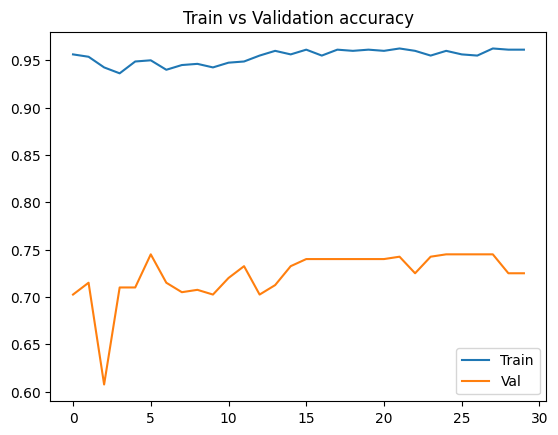

In [66]:
plt.plot(list(range(len(train_acc))),train_acc,val_acc[1:])
plt.legend(["Train","Val"])
plt.title("Train vs Validation accuracy")
plt.show()

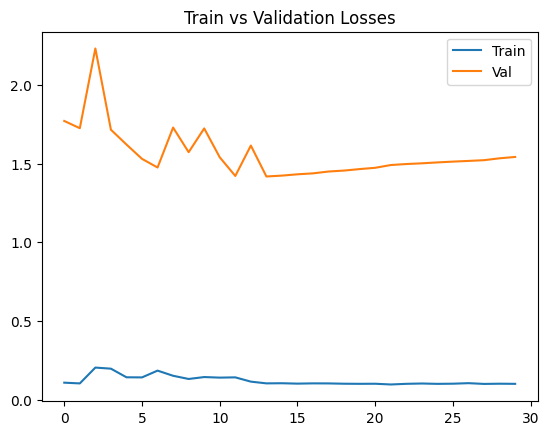

In [67]:
plt.plot(list(range(len(train_loss))),train_loss,val_loss[1:])
plt.legend(["Train","Val"])
plt.title("Train vs Validation Losses")
plt.show()

Here we used only 100 samples per class divided into train(800), test(400) and validation(400) images. Training on full dataset will definitely imrpove results.

In [68]:
from sklearn.metrics import classification_report,accuracy_score
def evaluate_model(model,data_loader,ds=""):
    # we can now evaluate the network on the test set
    print(f"[INFO] evaluating network on {ds}set...")
    # turn off autograd for testing evaluation
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()

        # initialize a list to store our predictions
        preds = []
        true = []
        # loop over the test set
        for i,batch in enumerate(data_loader):
              input_ids = batch["input_ids"].to(device)
              bbox = batch["bbox"].to(device)
              attention_mask = batch["attention_mask"].to(device)
              token_type_ids = batch["token_type_ids"].to(device)
              labels = batch["label"].to(device)

              voutputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,labels=labels)
              preds.extend(voutputs.logits.argmax(axis=1).cpu().tolist())
              true.extend(labels.cpu().tolist())

    # generate a classification report
    print(classification_report(true,
        preds, target_names=list(label2idx.keys())))
    print(f"{ds} Accuracy: ",accuracy_score(true,preds))

In [69]:
evaluate_model(model,train_loader,ds="Train ")

[INFO] evaluating network on Train set...
                        precision    recall  f1-score   support

                letter       1.00      1.00      1.00        50
                  form       1.00      1.00      1.00        50
                 email       1.00      1.00      1.00        50
           handwritten       0.61      1.00      0.76        50
         advertisement       1.00      0.80      0.89        50
     scientific report       1.00      0.96      0.98        50
scientific publication       1.00      1.00      1.00        50
         specification       1.00      1.00      1.00        50
           file folder       1.00      0.74      0.85        50
          news article       1.00      0.98      0.99        50
                budget       1.00      0.96      0.98        50
               invoice       1.00      1.00      1.00        50
          presentation       1.00      0.98      0.99        50
         questionnaire       1.00      0.98      0.99        

In [70]:
evaluate_model(model,val_loader,ds="Validation ")

[INFO] evaluating network on Validation set...
                        precision    recall  f1-score   support

                letter       0.66      0.76      0.70        25
                  form       0.61      0.68      0.64        25
                 email       0.96      0.92      0.94        25
           handwritten       0.47      0.76      0.58        25
         advertisement       0.80      0.48      0.60        25
     scientific report       0.71      0.60      0.65        25
scientific publication       0.86      0.72      0.78        25
         specification       0.80      0.96      0.87        25
           file folder       0.60      0.48      0.53        25
          news article       0.65      0.80      0.71        25
                budget       0.75      0.60      0.67        25
               invoice       0.72      0.72      0.72        25
          presentation       0.60      0.60      0.60        25
         questionnaire       0.86      0.76      0.81   

In [71]:
!wget https://4.bp.blogspot.com/-yQ58vS5fsg8/UmQkwjmlm_I/AAAAAAAAAZU/fpWTC0lMJdo/s1600/img001.jpg -O eg.jpg

--2023-12-07 12:14:23--  https://4.bp.blogspot.com/-yQ58vS5fsg8/UmQkwjmlm_I/AAAAAAAAAZU/fpWTC0lMJdo/s1600/img001.jpg
Resolving 4.bp.blogspot.com (4.bp.blogspot.com)... 209.85.147.132, 2607:f8b0:4001:c20::84
Connecting to 4.bp.blogspot.com (4.bp.blogspot.com)|209.85.147.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180246 (176K) [image/jpeg]
Saving to: ‘eg.jpg’

eg.jpg              100%[===================>] 176.02K  --.-KB/s    in 0.001s  

2023-12-07 12:14:23 (118 MB/s) - ‘eg.jpg’ saved [180246/180246]



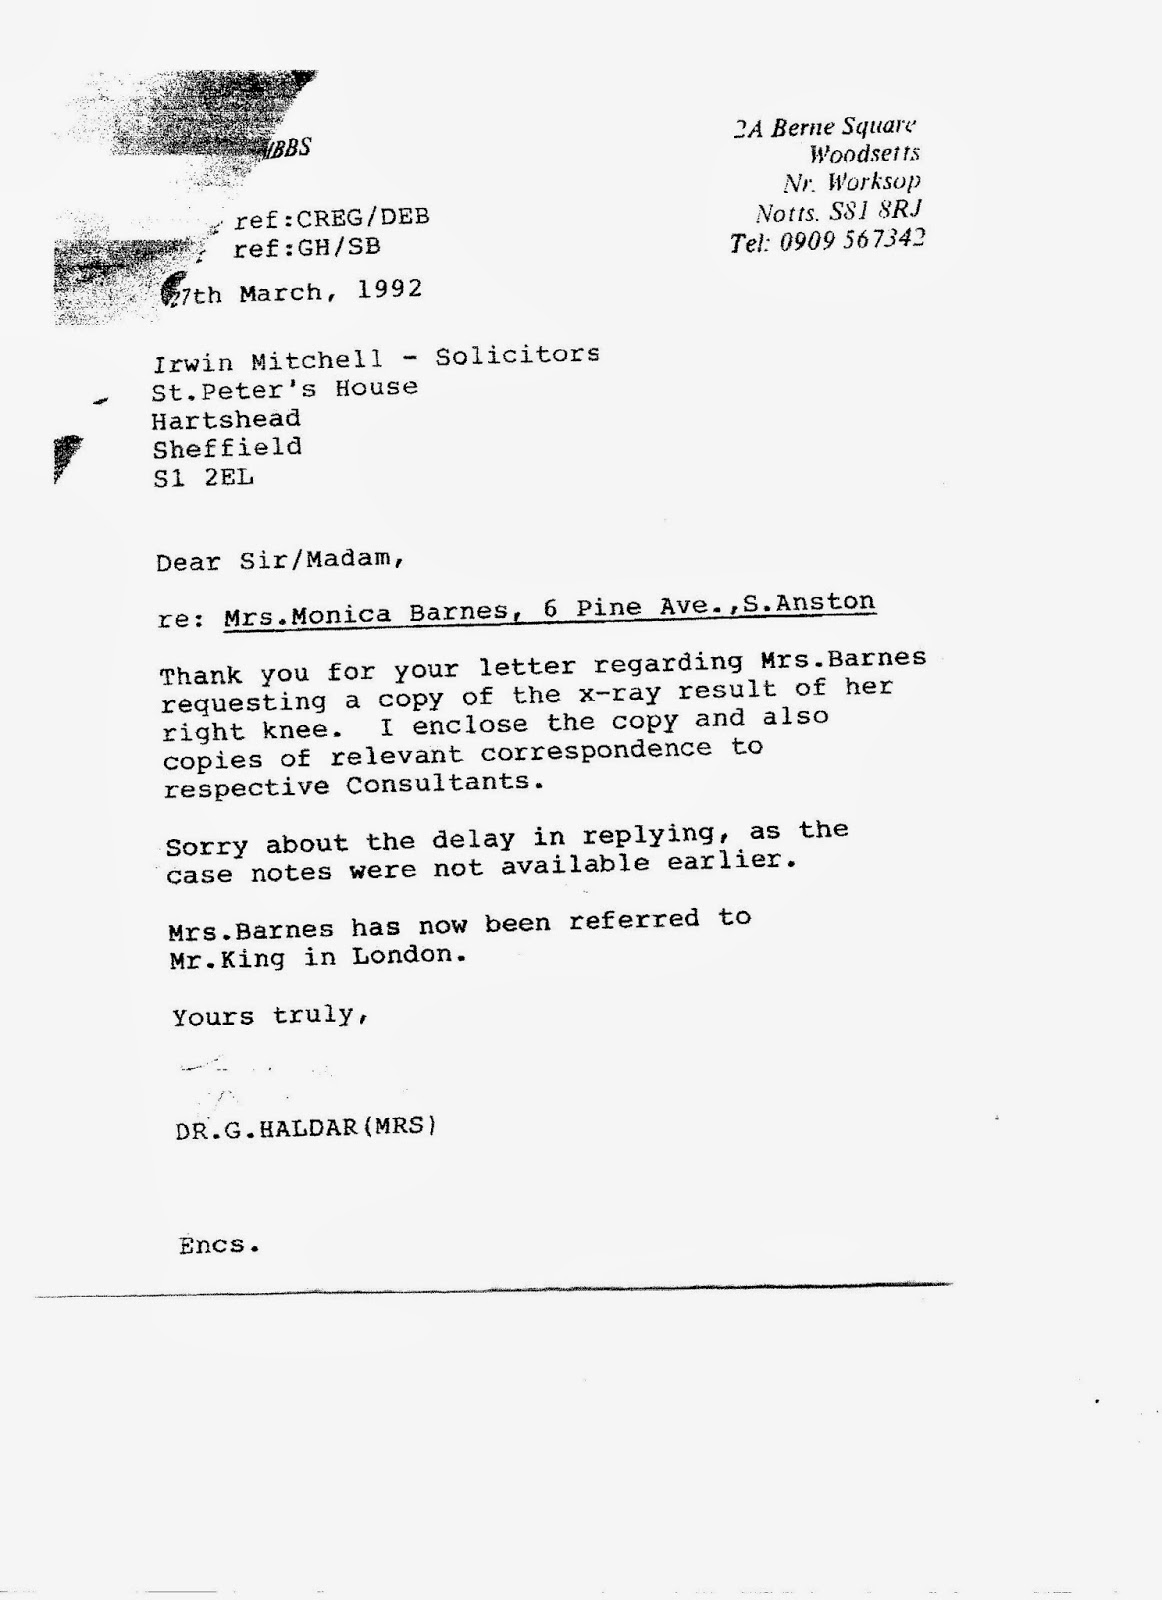

In [74]:
eg = Image.open("eg.jpg")
eg = eg.convert("RGB")
eg

In [75]:
eg = apply_ocr({"image":eg})

In [76]:
eg = encode_example(eg, max_seq_length=512)

In [77]:
for k,v in eg.items():
  eg[k] = torch.tensor(v).unsqueeze(0).cuda()

In [78]:
op = model(input_ids=eg["input_ids"], bbox=eg["bbox"], attention_mask=eg["attention_mask"], token_type_ids=eg["token_type_ids"])

In [79]:
idx2label[op.logits.argmax(1).item()]

'letter'

### Ooohhooh!